<h2>Data Manipulation</h2>

In order to start the data analysis, we will need to import a variety of packages.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import math
import statsmodels.api as sm
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from wordcloud import WordCloud, STOPWORDS

We will read in the data, which was downloaded from the Airbnb website and look at its info.

In [2]:
# Read in data
dat = pd.read_csv('datas/listings.csv')
dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6455 entries, 0 to 6454
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            6455 non-null   int64  
 1   listing_url                                   6455 non-null   object 
 2   scrape_id                                     6455 non-null   int64  
 3   last_scraped                                  6455 non-null   object 
 4   name                                          6455 non-null   object 
 5   description                                   6441 non-null   object 
 6   neighborhood_overview                         4703 non-null   object 
 7   picture_url                                   6455 non-null   object 
 8   host_id                                       6455 non-null   int64  
 9   host_url                                      6455 non-null   o

We can see that there are 74 columns, and 6,366 observations, however some values are missing in various columns.

In [3]:
test = dat['calendar_last_scraped'] == dat['last_scraped']

In [4]:
test.unique()

array([ True, False])

<h2>Data Cleansing</h2>

<h4>Drop off irrelevant columns and drop off reasons :</h4>

* URLs will not be useful
* Empty columns: **'neighborhood_group_cleansed'**, **'bathrooms'**, **'calendar_updated'**
* **'neighborhood'** column only has blank values or **'Chicago, Illinois, United States'** value, making it useless
* Drop **'host_listings_count'** and **'host_total_listings_count'**, use the calculated_host_listings columns, because values are the same.
* **'scrape_id'** is all the same value and not useful for our needs
* **'calendar_last_scraped'** can be dropped (same value as **'last_scraped'**)

In [5]:
dat = dat.drop(['scrape_id','listing_url','host_url','host_thumbnail_url','host_picture_url','picture_url',
               'neighbourhood_group_cleansed','bathrooms','calendar_updated','neighbourhood',
               'calendar_last_scraped','host_listings_count','host_total_listings_count'], axis = 1)

<h4>Bathrooms Column:</h4>

In [6]:
dat = dat.rename(columns={'id':'property_id', 'bathrooms_text':'bathrooms'})

In [7]:
dat['bathrooms'].unique()

array(['1 shared bath', '1 bath', '1 private bath', '2 baths',
       '1.5 shared baths', '1.5 baths', '3 baths', '2 shared baths',
       '2.5 baths', '0 baths', '3.5 baths', '11 shared baths', nan,
       '0 shared baths', '2.5 shared baths', 'Private half-bath',
       '3 shared baths', '4 baths', '5 baths', 'Shared half-bath',
       '4.5 baths', '11.5 shared baths', '4 shared baths', '6.5 baths',
       '7 baths', '5.5 baths', '6 baths', 'Half-bath', '8 shared baths',
       '12.5 baths', '10 baths', '7.5 baths'], dtype=object)

Looking at the 'bathrooms_text' column, we see that it is not very usable in its current state.  We will split the bathroom text column into two: one containing a float variable for the number of bathrooms, and the other an additional descriptor of the bathroom (shared/private).

In [8]:
# First let us make all text lowercase to simplify string manipulation
# dat['bathrooms'] = dat['bathrooms'].str.lower()

# Next we must convert any text 'half' to 0.5 so it is included in the subsequent number extraction
#dat['bathrooms'] = dat['bathrooms'].str.replace(r'(half)+','0.5', regex = True)

# Then extract the numbers into the new 'bathrooms' float32 data type column
#dat['bathrooms'] = dat['bathrooms'].str.extract(r'(\d+\.?\d*)', expand = True).astype(np.float32)

# This leaves us with only float and NaN values
#dat['bathrooms'].unique()
# First let us split the text by white space
bath = dat['bathrooms'].str.split(' ', expand = True)
bath

,0,1,2
0,1,shared,bath
1,1,bath,None
2,1,bath,None
3,1,bath,None
4,1,private,bath
...,...,...,...
6450,1,bath,None
6451,1,bath,None
6452,1,bath,None
6453,1,bath,None


In [9]:
# then drop column 1 and 2, keep column 0
bath = bath.drop([1,2], axis=1)
dat['bathrooms'] = bath[0].replace(['Private', 'Shared', 'Half-bath'], '0.5')
dat['bathrooms'] = dat['bathrooms'].astype('float')
dat['bathrooms'].unique()

array([ 1. ,  2. ,  1.5,  3. ,  2.5,  0. ,  3.5, 11. ,  nan,  0.5,  4. ,
        5. ,  4.5, 11.5,  6.5,  7. ,  5.5,  6. ,  8. , 12.5, 10. ,  7.5])

Above are the unique values left for the float variable in the column 'bathrooms'.

In [10]:
dat['bathrooms'].value_counts()

1.0     4504
2.0     1145
1.5      285
2.5      184
3.0      134
3.5       72
4.0       52
4.5       19
0.0       13
6.0        9
0.5        9
5.0        8
11.0       4
7.0        3
6.5        2
5.5        1
12.5       1
7.5        1
10.0       1
11.5       1
8.0        1
Name: bathrooms, dtype: int64

This leaves us with only 1,587 observations with one of the bathroom descriptors, 'shared' or 'private'; the rest are missing values since the original data did not contain text for them.

<h4>DateTime Columns:</h4>

Next, let's convert the datetime columns into the proper datatype.

In [11]:
# Convert dates to datetime data type
for x in ['last_scraped', 'host_since', 'first_review', 'last_review']:
    dat[x] = pd.to_datetime(dat[x])

**Create a new column to get how long the host exist**

In [12]:
dat['host_period'] = dat['last_scraped'] - dat['host_since']

<h4>Rate Columns:</h4>

In [13]:
dat['host_response_rate'].sample(5)

4067    100%
1777     NaN
4458    100%
3901    100%
3430     95%
Name: host_response_rate, dtype: object

We can see that we will need to convert the percentage columns ('host_response_rate' and 'host_acceptance_rate') into float variables.

In [14]:
# Convert host response rate and acceptance rate columns into float

dat['host_response_rate'] = dat['host_response_rate'].str.replace(r'(\D)','', regex = True).astype(np.float32)/100
dat['host_acceptance_rate'] = dat['host_acceptance_rate'].str.replace(r'(\D)','', regex = True).astype(np.float32)/100
dat['host_response_rate'].sample(5)

1343    NaN
95      0.5
5594    1.0
6101    1.0
1965    NaN
Name: host_response_rate, dtype: float32

<h4>Boolean Columns:</h4>

In [15]:
dat['host_is_superhost'].unique()

array(['t', 'f', nan], dtype=object)

We will convert the 't' and 'f' values to binary float values for later analysis, where 1 will mean "True".

In [16]:
# Map superhost column to boolean values
def repl_f_t(l):
    l = l.replace('f', 0)
    l = l.replace('t', 1);
    return l
dat['host_is_superhost'] = repl_f_t(dat['host_is_superhost']).astype('float');
dat['host_identity_verified'] = repl_f_t(dat['host_identity_verified']).astype('float')
dat['instant_bookable'] = repl_f_t(dat['instant_bookable']).astype('float')
dat['host_has_profile_pic'] = repl_f_t(dat['host_has_profile_pic']).astype('float')
dat['has_availability'] = repl_f_t(dat['has_availability']).astype('float')

#dat['host_is_superhost'] = dat['host_is_superhost'].map({'t':1,'f':0}).astype('float')
#dat['host_has_profile_pic'] = dat['host_has_profile_pic'].map({'t':1,'f':0}).astype('float')
#dat['host_identity_verified'] = dat['host_identity_verified'].map({'t':1,'f':0}).astype('float')
#dat['has_availability'] = dat['has_availability'].map({'t':1,'f':0}).astype('float')
#dat['instant_bookable'] = dat['instant_bookable'].map({'t':1,'f':0}).astype('float')

In [17]:
dat['host_is_superhost']

0       1.0
1       1.0
2       1.0
3       0.0
4       0.0
       ... 
6450    0.0
6451    0.0
6452    1.0
6453    1.0
6454    1.0
Name: host_is_superhost, Length: 6455, dtype: float64

<h4>Price Column:</h4>

Convert the price column to a float data type.

In [18]:
dat['price'] = dat['price'].str.extract(r'(\d+\.\d+)').astype(np.float64)

In [19]:
dat['price'].sample(5)

1092    189.0
4521    150.0
4835     25.0
4627    169.0
2527     35.0
Name: price, dtype: float64

In [20]:
dat['license'].sample(20)

499                                  R18000036981
2335                    City registration pending
954                     City registration pending
1456                    City registration pending
3220                                 R19000043481
522                     City registration pending
4735    Chicago Registration Number: R20000058883
1748                                 R18000023329
4040                                 R19000051609
6302                                 R21000060981
6067                             32+ Days Listing
1594                                 R19000050939
5718                                   Registered
860                                  R17000013633
4176                    City registration pending
3986                                 R19000046212
651                     City registration pending
4244                    City registration pending
1641                                 R20000054179
4317                                 R20000054741


Convert license to binary value: 1 = host have license number, 0 = host do not have license number

In [21]:
#dat = dat.drop(['license'], axis=1)
dat['have_license'] = dat['license'].isnull()
dat['have_license'] = dat['have_license'].map({False:1, True:0})
dat

,property_id,last_scraped,name,description,neighborhood_overview,host_id,host_name,host_since,host_location,host_about,...,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,host_period,have_license
0,2384,2021-09-17,Hyde Park - Walk to University of Chicago,"If you have been fully vaccinated, you are inv...",The apartment is less than one block from beau...,2613,Rebecca,2008-08-29,"Chicago, Illinois, United States",My 2 bdrm apartment is a 2nd floor walk-up in ...,...,4.94,R17000015609,0.0,1,0,1,0,2.42,4767 days,1
1,7126,2021-09-17,Tiny Studio Apartment 94 Walk Score,A very small studio in a wonderful neighborhoo...,"Ukrainian Village was just named ""Hottest Neig...",17928,Sarah,2009-05-19,"Chicago, Illinois, United States",We live in Chicago. We love to travel and see ...,...,4.72,R18000034991,0.0,1,1,0,0,3.29,4504 days,1
2,10945,2021-09-16,The Biddle House (#1),Beautiful first floor apartment in Historic Ol...,NaN,33004,At Home Inn,2009-08-21,"Chicago, Illinois, United States","Hi, we're Bob and Liz Biddle, long time Chicag...",...,4.58,2120297,1.0,4,4,0,0,0.37,4409 days,1
3,12068,2021-09-16,Chicago GOLD COAST 1 Bedroom Condo,Available as extended stay rental located in C...,The condo is on Lasalle just off of Division; ...,40731,Dominic,2009-09-23,"New York, New York, United States",NYC,...,4.75,City registration pending,0.0,1,1,0,0,0.15,4376 days,1
4,12140,2021-09-17,Lincoln Park Guest House,Bed and Breakfast license issued by the City o...,The Guest House is in the heart of Chicago's m...,46734,Sharon And Robert,2009-10-18,"Chicago, Illinois, United States",Best in the city with long-time urban-dwelling...,...,5.00,R20000055258,0.0,1,0,1,0,0.09,4352 days,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6450,52247486,2021-09-17,Modern Suite in the Heart of UIC Medical District,Unwind and enjoy the city in our cozy and clea...,We are located in a quiet neighborhood that's ...,418584416,Nachole,2021-08-15,US,NaN,...,NaN,2808664,1.0,3,3,0,0,NaN,33 days,1
6451,52256903,2021-09-16,Fully equipped apartment home | Jr. 1 BR in Ch...,Stay for 33+ nights (minimum nights and rates ...,NaN,343006378,Kia,2020-04-02,US,NaN,...,NaN,NaN,1.0,24,24,0,0,NaN,532 days,0
6452,52267186,2021-09-16,Amazing Gold Coast studio for rental,This location in the Gold Coast is about as go...,Living in the Gold Coast puts you front and ce...,352627300,Azhar,2020-06-30,"Chicago, Illinois, United States","PHD Student, living the American dream. Chicag...",...,NaN,R21000063283,1.0,2,1,1,0,NaN,443 days,1
6453,52281271,2021-09-17,3 blocks from UChicago Medical Center. TRAIN.,LOCATION LOCATION! Walking distance to the Uni...,NaN,1385332,Patt,2011-11-08,"Chicago, Illinois, United States",Hi! I am a friendly and easy-going host. My ba...,...,NaN,NaN,0.0,12,3,9,0,NaN,3601 days,0


**Remove duplicate rows from dataset**

In [22]:
dat = dat.drop_duplicates()

In [23]:
dat = dat.loc[:,~dat.columns.duplicated()]
dat.head()

,property_id,last_scraped,name,description,neighborhood_overview,host_id,host_name,host_since,host_location,host_about,...,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,host_period,have_license
0,2384,2021-09-17,Hyde Park - Walk to University of Chicago,"If you have been fully vaccinated, you are inv...",The apartment is less than one block from beau...,2613,Rebecca,2008-08-29,"Chicago, Illinois, United States",My 2 bdrm apartment is a 2nd floor walk-up in ...,...,4.94,R17000015609,0.0,1,0,1,0,2.42,4767 days,1
1,7126,2021-09-17,Tiny Studio Apartment 94 Walk Score,A very small studio in a wonderful neighborhoo...,"Ukrainian Village was just named ""Hottest Neig...",17928,Sarah,2009-05-19,"Chicago, Illinois, United States",We live in Chicago. We love to travel and see ...,...,4.72,R18000034991,0.0,1,1,0,0,3.29,4504 days,1
2,10945,2021-09-16,The Biddle House (#1),Beautiful first floor apartment in Historic Ol...,NaN,33004,At Home Inn,2009-08-21,"Chicago, Illinois, United States","Hi, we're Bob and Liz Biddle, long time Chicag...",...,4.58,2120297,1.0,4,4,0,0,0.37,4409 days,1
3,12068,2021-09-16,Chicago GOLD COAST 1 Bedroom Condo,Available as extended stay rental located in C...,The condo is on Lasalle just off of Division; ...,40731,Dominic,2009-09-23,"New York, New York, United States",NYC,...,4.75,City registration pending,0.0,1,1,0,0,0.15,4376 days,1
4,12140,2021-09-17,Lincoln Park Guest House,Bed and Breakfast license issued by the City o...,The Guest House is in the heart of Chicago's m...,46734,Sharon And Robert,2009-10-18,"Chicago, Illinois, United States",Best in the city with long-time urban-dwelling...,...,5.00,R20000055258,0.0,1,0,1,0,0.09,4352 days,1


**Dummy Variable**

In [24]:
x = pd.get_dummies(dat['host_is_superhost'])
dat = pd.concat([dat,x], axis=1)
dat = dat.rename(columns={0.0:'host_is_superhost_f', 1.0:'host_is_superhost_t'})

In [25]:
x1 = pd.get_dummies(dat['host_identity_verified'])
dat = pd.concat([dat,x1], axis=1)
dat = dat.rename(columns={0.0:'host_identity_verified_f', 1.0:'host_identity_verified_t'})

In [26]:
x2 = pd.get_dummies(dat['instant_bookable'])
dat = pd.concat([dat,x2], axis=1)
dat = dat.rename(columns={0.0:'instant_bookable_f', 1.0:'instant_bookable_t'})

In [27]:
x2 = pd.get_dummies(dat['host_has_profile_pic'])
dat = pd.concat([dat,x2], axis=1)
dat = dat.rename(columns={0.0:'host_has_profile_pic_f', 1.0:'host_has_profile_pic_t'})

In [28]:
x2 = pd.get_dummies(dat['has_availability'])
dat = pd.concat([dat,x2], axis=1)
dat = dat.rename(columns={0.0:'has_availability_f', 1.0:'has_availability_t'})

In [29]:
dat.drop(['host_is_superhost_f', 'host_identity_verified_f', 'instant_bookable_f', 'host_has_profile_pic_f', 'has_availability_f'],axis=1).head()

,property_id,last_scraped,name,description,neighborhood_overview,host_id,host_name,host_since,host_location,host_about,...,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,host_period,have_license,host_is_superhost_t,host_identity_verified_t,instant_bookable_t,host_has_profile_pic_t,has_availability_t
0,2384,2021-09-17,Hyde Park - Walk to University of Chicago,"If you have been fully vaccinated, you are inv...",The apartment is less than one block from beau...,2613,Rebecca,2008-08-29,"Chicago, Illinois, United States",My 2 bdrm apartment is a 2nd floor walk-up in ...,...,1,0,2.42,4767 days,1,1,1,0,1,1
1,7126,2021-09-17,Tiny Studio Apartment 94 Walk Score,A very small studio in a wonderful neighborhoo...,"Ukrainian Village was just named ""Hottest Neig...",17928,Sarah,2009-05-19,"Chicago, Illinois, United States",We live in Chicago. We love to travel and see ...,...,0,0,3.29,4504 days,1,1,1,0,1,1
2,10945,2021-09-16,The Biddle House (#1),Beautiful first floor apartment in Historic Ol...,NaN,33004,At Home Inn,2009-08-21,"Chicago, Illinois, United States","Hi, we're Bob and Liz Biddle, long time Chicag...",...,0,0,0.37,4409 days,1,1,1,1,1,1
3,12068,2021-09-16,Chicago GOLD COAST 1 Bedroom Condo,Available as extended stay rental located in C...,The condo is on Lasalle just off of Division; ...,40731,Dominic,2009-09-23,"New York, New York, United States",NYC,...,0,0,0.15,4376 days,1,0,1,0,1,1
4,12140,2021-09-17,Lincoln Park Guest House,Bed and Breakfast license issued by the City o...,The Guest House is in the heart of Chicago's m...,46734,Sharon And Robert,2009-10-18,"Chicago, Illinois, United States",Best in the city with long-time urban-dwelling...,...,1,0,0.09,4352 days,1,0,1,0,1,1


**Missing value**

In [30]:
pd.set_option('display.max_rows',100)
dat.isnull().sum()

property_id                                        0
last_scraped                                       0
name                                               0
description                                       14
neighborhood_overview                           1752
host_id                                            0
host_name                                         10
host_since                                        10
host_location                                     20
host_about                                      2060
host_response_time                              1378
host_response_rate                              1378
host_acceptance_rate                            1170
host_is_superhost                                 10
host_neighbourhood                               478
host_verifications                                 0
host_has_profile_pic                              10
host_identity_verified                            10
neighbourhood_cleansed                        

For columns: **'host_response_time'**, convert to binary value and create a new column represent if a host respose in a day.

In [31]:
dat['host_response_time'].unique()

array(['within an hour', 'within a few hours', nan, 'within a day',
       'a few days or more'], dtype=object)

In [32]:
#Categorical within an hour,within a few hours, within a day to 1(true), NaN,a few days or more to 0(false) 
dat['host_response_inADay'] = dat.host_response_time.map({'within an hour': 1, 
                                                        'within a few hours': 1, 
                                                        'within a day':1, 
                                                        'a few days or more':0, 
                                                        np.nan:0})
dat['host_response_inADay'].unique()

array([1, 0], dtype=int64)

For columns: **description**, **neighborhood_overview**, **host_location**, **host_about**, **host_neighbourhood**
     using 'Unknown' to fill the missing value, because these columns does not have direct effect on project topic.

In [33]:
dat['description'].fillna(value='Unknown', inplace=True)

dat['neighborhood_overview'].fillna(value='Unknown', inplace=True)

dat['host_location'].fillna(value='Unknown', inplace=True)

dat['host_about'].fillna(value='Unknown', inplace=True)

dat['host_neighbourhood'].fillna(value='Unknown', inplace=True)

For columns: **host_name**, **host_since**, **host_has_profile_pic**, **host_identity_verified**, it is easy to see below these 10 rows contains many NaN value, so drop directly.

In [34]:
dat[dat['host_name'].isnull()]

,property_id,last_scraped,name,description,neighborhood_overview,host_id,host_name,host_since,host_location,host_about,...,host_is_superhost_t,host_identity_verified_f,host_identity_verified_t,instant_bookable_f,instant_bookable_t,host_has_profile_pic_f,host_has_profile_pic_t,has_availability_f,has_availability_t,host_response_inADay
690,10765065,2021-09-17,Private Room w/ Bath near U of C,Renovated 2 bed/2 bath condo in Hyde Park Neig...,This Hyde Park condo is located within walking...,13893889,NaN,NaT,Unknown,Unknown,...,0,0,0,1,0,0,0,0,1,0
744,11866232,2021-09-16,2Bed 2Bath Hyde Park Condo,Renovated 2 bed/2 bath condo in Hyde Park Neig...,This Hyde Park condo is located within walking...,13893889,NaN,NaT,Unknown,Unknown,...,0,0,0,1,0,0,0,0,1,0
1541,20727489,2021-09-16,❤ Instagram worthy view! Luxury High-rise Down...,Amazing studio unit in a luxury high-rise with...,Unknown,34622220,NaN,NaT,Unknown,Unknown,...,0,0,0,1,0,0,0,0,1,0
2705,31055263,2021-09-16,Logan Square Duplex Smart Home w/Garage by 606...,Cozy three bedroom townhome with additional sl...,"In Logan square, and Humboldt park. Close to t...",14657995,NaN,NaT,Unknown,Unknown,...,0,0,0,0,1,0,0,0,1,0
3189,35743481,2021-09-16,Chicago Amazing Logan Square Comfy Clean Space...,Greystone walk up SANITIZED CLEANINGS heart of...,The location is 4 miles to Wrigley Field to se...,19691906,NaN,NaT,Unknown,Unknown,...,0,0,0,1,0,0,0,0,1,0
3240,36174506,2021-09-17,Chicago Trendy Logan Square Super Clean Space 3br,Greystone walk up SANITIZED CLEANINGS heart of...,The location is 4 miles to Wrigley Field to se...,19691906,NaN,NaT,Unknown,Unknown,...,0,0,0,1,0,0,0,0,1,0
3630,38842498,2021-09-17,The Grand Kimball Lodge - Perfect Logan Square...,"In the heart of vibrant Logan Square, this eno...",Cheap eats and bike-friendly streets. Gourmet ...,26633669,NaN,NaT,Unknown,Unknown,...,0,0,0,1,0,0,0,0,1,0
3965,40780053,2021-09-17,2239 N Kimball WH,This perfect Logan Square lodge boasts enormou...,Cheap eats and bike-friendly streets. Gourmet ...,26633669,NaN,NaT,Unknown,Unknown,...,0,0,0,1,0,0,0,0,1,0
4671,45116890,2021-09-17,Designer 2 Bed/2 Bath in the ♡ of Wicker Park!,"Relax in this spacious 2 bed, 2 bath apartment...",One of Chicago's creative epicenters lies just...,68242483,NaN,NaT,Unknown,Unknown,...,0,0,0,1,0,0,0,0,1,0
5755,49748131,2021-09-16,Modern Guest Suite (Lower level),((Absolutely No Refund)) Enjoy your stay at th...,Five minutes from the expressway. Twenty minut...,85015661,NaN,NaT,Unknown,Unknown,...,0,0,0,0,1,0,0,0,1,0


In [35]:
dat.drop([dat.index[690], dat.index[744], dat.index[1541], dat.index[2705], dat.index[3189], dat.index[3240], dat.index[3630],
                dat.index[3965], dat.index[4671], dat.index[5755]],inplace = True)
dat.reset_index(drop=True, inplace=True)
dat[dat['host_name'].isnull()]

,property_id,last_scraped,name,description,neighborhood_overview,host_id,host_name,host_since,host_location,host_about,...,host_is_superhost_t,host_identity_verified_f,host_identity_verified_t,instant_bookable_f,instant_bookable_t,host_has_profile_pic_f,host_has_profile_pic_t,has_availability_f,has_availability_t,host_response_inADay


For columns: **bedrooms** and **beds**, using mode to fill missing value, because fill with natural value to make the result less biased. 

In [36]:
dat['bedrooms'].mode()

0    1.0
dtype: float64

In [37]:
dat['bedrooms'].fillna(value=1.0, inplace=True)

In [38]:
dat['bedrooms'].isnull().sum()

0

In [39]:
dat['beds'].mode()

0    1.0
dtype: float64

In [40]:
dat['beds'].fillna(value=1.0, inplace=True)

In [41]:
dat['bedrooms'].isnull().sum()

0

For columns: **first_review**, **last_review**, **review_scores_rating**, **review_scores_accuracy**, **review_scores_cleanliness**, **review_scores_checkin**, **review_scores_communication**, **review_scores_location**, **review_scores_value**, **reviews_per_month**, most missing value caused by 'number_of_reviews'==0. So, fill those missing value with 0.0. Later review analysis process will exclude these rows since no number of reviews.

In [42]:
pd.set_option('display.max_columns',100)
dat[dat['number_of_reviews']==0]

,property_id,last_scraped,name,description,neighborhood_overview,host_id,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,host_period,have_license,host_is_superhost_f,host_is_superhost_t,host_identity_verified_f,host_identity_verified_t,instant_bookable_f,instant_bookable_t,host_has_profile_pic_f,host_has_profile_pic_t,has_availability_f,has_availability_t,host_response_inADay
61,789429,2021-09-17,Guest bedroom with private bath,<b>The space</b><br />Italian style beautiful ...,Unknown,1185573,Graz Anton,2011-09-20,"Chicago, Illinois, United States",Italian-born professional based in Chicago who...,NaN,NaN,NaN,0.0,Uptown,"['email', 'phone', 'facebook', 'reviews', 'kba']",1.0,1.0,Uptown,41.961930,-87.662380,Private room in condominium (condo),Private room,2,1.0,1.0,1.0,"[""Wifi"", ""Heating"", ""Dishes and silverware"", ""...",49.0,180,365,180,180,365,365,180.0,365.0,1.0,30,60,90,365,0,0,0,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,City registration pending,0.0,3,1,2,0,NaN,3650 days,1,1,0,0,1,1,0,0,1,0,1,0
68,887357,2021-09-16,"Prime Lincoln Park 2/2 - 2 Decks, Garage, Dogs OK","Located on a quiet side street, 2 bedroom, 2 f...",Lincoln Park is a great neighborhood where peo...,101521,Red,2010-03-31,"Chicago, Illinois, United States",Travel is fun and exciting but can be hard on ...,within an hour,1.00,0.83,0.0,Lincoln Park,"['email', 'phone', 'reviews', 'jumio', 'offlin...",1.0,1.0,Lincoln Park,41.930320,-87.657870,Entire rental unit,Entire home/apt,5,0.0,2.0,0.0,"[""Outdoor furniture"", ""Patio or balcony"", ""Lon...",184.0,32,360,32,32,360,360,32.0,360.0,1.0,0,0,0,0,0,0,0,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,4,4,0,0,NaN,4187 days,0,1,0,0,1,1,0,0,1,0,1,1
125,1755737,2021-09-17,"Lake View 2BR/2Bath w/ Pool, Gym. Annual lease.",Enjoy breathtaking unobstructed lake and sunri...,Convenient and Coveted Location:<br /><ul><br ...,9233414,Ravi,2013-10-04,"Chicago, Illinois, United States",Unknown,NaN,NaN,NaN,0.0,Lakeview,"['email', 'phone', 'reviews', 'offline_governm...",1.0,1.0,Lake View,41.940360,-87.640680,Entire condominium (condo),Entire home/apt,2,2.0,2.0,2.0,"[""Refrigerator"", ""Microwave"", ""Wifi"", ""Heating...",155.0,365,730,365,365,730,730,365.0,730.0,1.0,29,59,89,364,0,0,0,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1,1,0,0,NaN,2905 days,0,1,0,0,1,1,0,0,1,0,1,0
135,1852665,2021-09-16,BIG LOFT Location RIVER WEST Brick,<b>The space</b><br />GREAT LOCATION !!! <br /...,Unknown,3965428,Rob,2012-10-24,"Chicago, Illinois, United States",My goal is to have all my guests have a comfor...,within an hour,0.96,0.51,1.0,Loop,"['email', 'phone', 'reviews', 'jumio', 'offlin...",1.0,1.0,Near West Side,41.885750,-87.650520,Entire rental unit,Entire home/apt,3,1.0,1.0,1.0,"[""Hair dryer"", ""Cable TV"", ""Essentials"", ""Free...",140.0,60,1125,60,60,1125,1125,60.0,1125.0,1.0,30,60,90,365,0,0,0,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,88,88,0,0,NaN,3249 days,0,0,1,0,1,1,0,0,1,0,1,1
355,5933672,2021-09-16,Luxurious 2br 2ba Condo RIVER WEST,"Showroom like 2br 2 bath con

In [43]:
# first_review, last_review, will not be filled since no value suitable
dat['review_scores_rating'].fillna(value=0.0, inplace=True)

dat['review_scores_accuracy'].fillna(value=0.0, inplace=True)

dat['review_scores_cleanliness'].fillna(value=0.0, inplace=True)

dat['review_scores_checkin'].fillna(value=0.0, inplace=True)

dat['review_scores_communication'].fillna(value=0.0, inplace=True)

dat['review_scores_location'].fillna(value=0.0, inplace=True)

dat['review_scores_value'].fillna(value=0.0, inplace=True)

dat['reviews_per_month'].fillna(value=0.0, inplace=True)

In [50]:
dat.isnull().sum()

property_id                                        0
last_scraped                                       0
name                                               0
description                                        0
neighborhood_overview                              0
host_id                                            0
host_name                                          0
host_since                                         0
host_location                                      0
host_about                                         0
host_response_time                              1368
host_response_rate                              1368
host_acceptance_rate                            1160
host_is_superhost                                  0
host_neighbourhood                                 0
host_verifications                                 0
host_has_profile_pic                               0
host_identity_verified                             0
neighbourhood_cleansed                        

<h2>Data Exploration and Visualization</h2>

Let us explore the data in the dataset.

<h4>Unique Hosts</h4>

First, how many unique hosts are there?

In [45]:
dat['host_id'].nunique()

3380

In [46]:
listings_by_host = dat['host_id'].value_counts()
listings_by_host.describe()

count    3380.000000
mean        1.906805
std         5.870549
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max       283.000000
Name: host_id, dtype: float64

In [47]:
listings_by_host[listings_by_host > 1].count()

809

Here we can see that out of the 3,371 unique hosts, 799 have more than one listing in the Chicago area.  Interestingly, there is one host id with 260 listings.

Let's graph this data to see the distribution of hosts with differing numbers of listings.

AttributeError: 'AxesSubplot' object has no attribute 'bar_label'

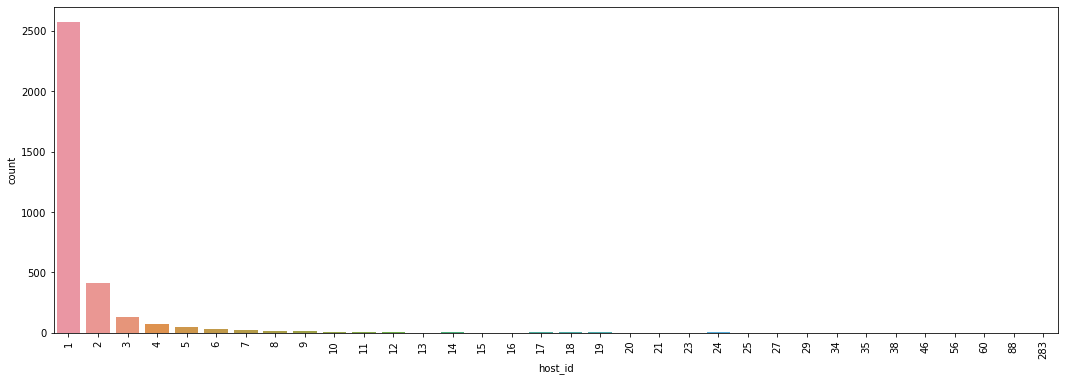

In [48]:
plt.figure(figsize=(18,6))
p = sb.countplot(x=listings_by_host, order=sorted(listings_by_host.unique()))
p.set_xticklabels(labels=p.get_xticklabels(),rotation=90)
p.bar_label(p.containers[0])
plt.xlabel('Number of Listings by Host')
plt.show()

It is obvious that a vast majority of hosts have only one listing in the Chicago area.

<h4>Host Response Time</h4>


In [ ]:
dat['host_response_time'].unique()

In [ ]:
plt.figure(figsize=(6,6))
p = sb.countplot(x='host_response_time',data = dat)
p.set_xticklabels(labels=p.get_xticklabels(),rotation=45)
p.bar_label(p.containers[0])
plt.xlabel('Host Response Time')
plt.show()

Here we can see there are four categories for the response time.  Let's define a system for rating the response time by using floating numbers.  We will assign the values in hours and as follows:
 * 'within an hour' = 1 hour
 * 'within a few hours' = 5 hours
 * 'within a day' = 24 hours
 * 'a few days or more' = 48 hours

In [ ]:
dat['host_response_time_float'] = dat['host_response_time'].map({'within an hour':1,'within a few hours':5,
                                                           'within a day':24,'a few days or more':48}).astype(np.float32)
dat['host_response_time_float'].unique()

<h4>Host Verifications</h4>

In order to simplify future analysis, let us count the number of verifications the host has and list this in a new column.

In [ ]:
dat['host_verifications'].sample(5)

We can see that the verifications are separated by a comma, so we will use this to count the number of verifications each host has.

In [ ]:
dat['no_of_verif'] = dat['host_verifications'].str.count(r',') + 1
dat.loc[:, ['host_verifications','no_of_verif']].head()

In order to catch any observations where hosts have no verifications, we will set the number of verifications to zero where the host_verifications = 'None'.  This is important since the code above would have counted 'none' and an observation without a comma (i.e. only one verification) as 1.

In [ ]:
dat['no_of_verif'] = np.where(dat['host_verifications'] == 'None', 0, dat['no_of_verif'])

In [ ]:
dat['no_of_verif'].describe()

On average, hosts have about 5-6 different identity verifications. 

In [ ]:
plt.figure(figsize=(18,6))
p = sb.countplot(x='no_of_verif',data = dat)
p.bar_label(p.containers[0])
plt.xlabel('Nomber of Identity Verifications by Host')
plt.show()

<h4>Amenities</h4>

Repeat the same process for number of amenities listed.

In [ ]:
dat['no_of_amen'] = dat['amenities'].str.count(r',') + 1
dat.loc[:, ['amenities','no_of_amen']].head()

In [ ]:
dat['no_of_amen'].describe()

In [ ]:
plt.figure(figsize=(18,6))
p = sb.countplot(x='no_of_amen',data = dat)
p.set_xticklabels(labels=p.get_xticklabels(),rotation=90)
plt.xlabel('Number of Amenities Listed by the Host')
plt.show()

<h4>Distance from Center of Chicago</h4>

Let's calculate the distance of the listing from the center of the city of Chicago.  We will use the following coordinates: 41.8781° N, 87.6298° W (source needed?).

We will use the Haversine formula to calculate the distance in miles.  In order to do so, we will first define a function to perform the calculation.

In [ ]:
# Coordinates for center of Chicago in degrees
lat1 = 41.8781
long1 = -87.6298

# Constant, radius of the Earth in miles
r = 3958.8

# Define a function to calculate the distance
def haversine(lat2, long2):
    # First convert degrees into radians:
    rlat1 = lat1 * (math.pi / 180)
    rlat2 = lat2 * (math.pi / 180)
    rlong1 = long1 * (math.pi / 180)
    rlong2 = long2 * (math.pi / 180)
    
    # Calculate the differnce between the latitudes and longitudes
    dlat = rlat1 - rlat2
    dlong = rlong1 - rlong2
    
    # Use the Haversine formula (broken into 3 terms for simplification here)
    a = (math.sin(dlat / 2) ** 2)         # First term
    b = math.cos(rlat1) * math.cos(rlat2) # Second term
    c = (math.sin(dlong / 2) ** 2)        # Third term
    e = math.sqrt(a + b * c)
    d = 2 * r * e                         # where r is the radius of the Earth
    return d

Then, apply the formula to each observation in the data set, returning the answer in a new column for the distance from the center of the city.

In [ ]:
dat['d_center'] = dat.apply(
    lambda row: haversine(row['latitude'], row['longitude']),
    axis=1)
dat['d_center'].sample(5)

In [ ]:
dat['d_center'].describe()

In order to visualize the distances, let us plot them against the listing price values.

In [ ]:
plt.figure(figsize=(12,8))
sb.regplot(x="d_center", y="price", 
            line_kws={"color":"r","alpha":0.5,"lw":3}, data=dat)
plt.xlabel('Distance from center of city (miles)')
plt.ylabel('Price ($)')
plt.show()

On first look, it appears that the listings further from the city are less valuable on average.

<h4>Property and Room Types</h4>

In [ ]:
plt.figure(figsize=(18,6))
p = sb.countplot(x='property_type',data = dat)
p.set_xticklabels(labels=p.get_xticklabels(),rotation=90)
plt.xlabel('Number of Amenities Listed by the Host')
plt.show()

In [ ]:
plt.figure(figsize=(12,6))
p = sb.countplot(x='room_type',data = dat)
plt.xlabel('Room Type')
plt.show()

<h2>Dimension Reduction</h2>



In [ ]:
dat.info()

In order to complete a Principal Component Analysis, we need to only select the numeric values and drop values with NaNs.

In [ ]:
# Select only numeric values
dat_pre_norm = dat.loc[:,['host_response_rate','host_acceptance_rate','host_is_superhost',
                         'host_total_listings_count','host_has_profile_pic',
                          'host_identity_verified','latitude','longitude','accommodates','bedrooms','beds',
                         'price','minimum_minimum_nights','maximum_minimum_nights',
                         'minimum_maximum_nights','maximum_maximum_nights','minimum_nights_avg_ntm',
                         'maximum_nights_avg_ntm','number_of_reviews','number_of_reviews_ltm','number_of_reviews_l30d',
                         'review_scores_rating','review_scores_accuracy','review_scores_cleanliness',
                         'review_scores_checkin','review_scores_communication','review_scores_location',
                         'review_scores_value','reviews_per_month']]
dat_pre_norm = dat_pre_norm.dropna()

In [ ]:
dat_norm = scale(dat_pre_norm)

For the fist PCA, we will include all of the variables (i.e. columns from the selection above).

In [ ]:
pca1 = PCA(n_components=len(dat_pre_norm.columns))

pca1.fit(dat_norm)

In [ ]:
var = pca1.explained_variance_ratio_
var1 = np.cumsum(np.round(pca1.explained_variance_ratio_, decimals=4)*100)
print(var1)

In [ ]:
var1 = pd.DataFrame(var1, index=np.arange(1,int(len(dat_pre_norm.columns))+1))
plt.plot(var1,color='blue')
plt.title('Scree Plot')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.show()

Taking the first 18 principal components will correspond to 90% of the variance explained.

In [ ]:
pca18 = PCA(n_components=18)
pca18.fit(dat_norm)
data_pca18 = pca18.transform(dat_norm)

# Convert the numpy array to pandas DataFrame
data_pca18 = pd.DataFrame(data_pca18)
data_pca18.columns = ["PC"+str(i) for i in range(1,19)]

In [ ]:
data_pca18.corr()

From the above correlation table, we can find that the pairwise correlations between two components are close to zeros. This means that all these components are orthogonal (not correlated). There is no multicollinearity among principal components.

# Word Cloud

In [ ]:
dat.head()

## 1. Property Description Word Cloud

In [ ]:
dat.head()

In [ ]:
stopwords = STOPWORDS
def Mywordcloud(data, title = None):   
    wc = WordCloud(
    background_color = "white",
    stopwords = stopwords,
    height = 600,
    width = 400
    ).generate(str(data))
    fig = plt.figure(1, figsize=(10, 10))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)
    plt.imshow(wc)
    plt.show()

In [ ]:
Mywordcloud(dat['description'].dropna())

In [ ]:
Mywordcloud(dat['neighborhood_overview'].dropna())

In [ ]:
Mywordcloud(dat['host_about'].dropna())